In [1]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Make RBC Model](#chapter1)
    * [Model Equations](#section_1_1)
    * [Find Steady State, Solve the Model](#section_1_2)
* [Get Italy data](#chapter2)
* [Preprocessing the data](#chapter3)
    * [Log-Transforming of the Data](#section_3_1)
    * [Detrending the Data](#section_3_2)
    * [Detrending the Data](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [MLE Kalman Filter Prediction](#section_4_1)
    * [Kalman Smoother output](#section_4_2)
    * [Impulse response](#section_4_3)

In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Get Italy data <a class="anchor" id="chapter2"></a>

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [176]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

data.drop(["X", "Z"], axis=1, inplace=True)

glob_cols = list(data.columns)
vars_to_plot = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In [134]:
# check for na
print("NaNs \n", data.isna().sum())

NaNs 
 Y     0
I     0
r     0
C     0
w    36
L     0
dtype: int64


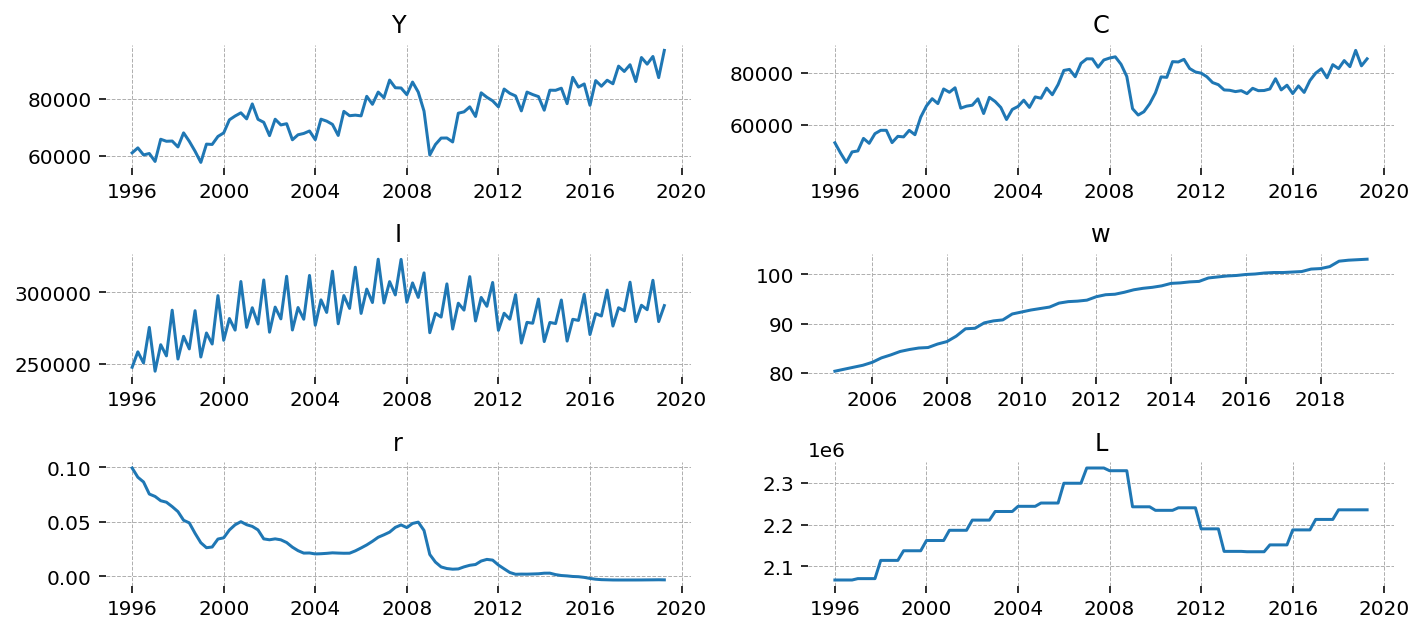

In [135]:
# raw data
plot_df(data)

#### Train Test Split

In [136]:
test_size = .15
test_index = len(data.index) - round(len(data.index) * test_size)
test_size = len(data) - test_index
print(f"Test size: {test_size}, \nTrain size: {test_index}")

Test size: 14, 
Train size: 80


In [137]:
train = data.iloc[:test_index].copy()
test = data.iloc[test_index:].copy()

### Log-transformation <a class="anchor" id="section_3_1"></a>

In [138]:
# log transform
for col in [item for item in glob_cols if item != "r"]:
    train[col] = apply_func(train[col], func=np.log)
    test[col] = apply_func(test[col], func=np.log)

Raw data is log transformed, thus somehow equalised in scale

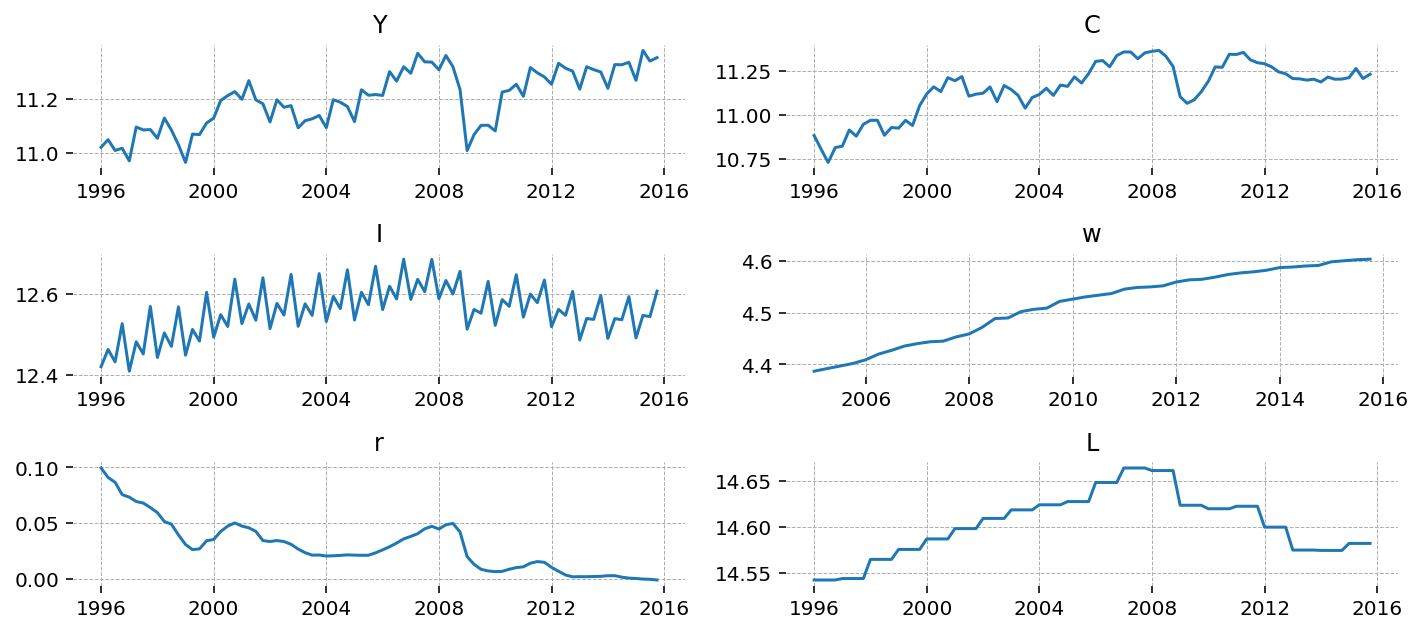

In [139]:
plot_df(train)

### Detrend the Data <a class="anchor" id="section_3_3"></a>

The HP filter identified the underlying trend. Yet the trend is by nature non-stationary, thus not suitable to most statistical procedures. For detrending we use a 2nd order polynomial detrender.

In [140]:
poly_order = {"Y": 1, 
              "C": 2, 
              "I": 2,
              "w": 1,
              "L": 2}
mask = train.copy()
for col in [item for item in glob_cols if item != 'r']:
    _ = train[col].dropna().copy()
    func_form = np.polyfit(list(range(0, len(_))), _, poly_order[col])
    
    train[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True)   
    mask[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True, return_pred=True)
       
    test[col] = np.polyval(func_form, test[col])

In [141]:
train['r'] = (train['r'] - train['r'].mean())
test['r']  = (test['r'] - train['r'].mean())

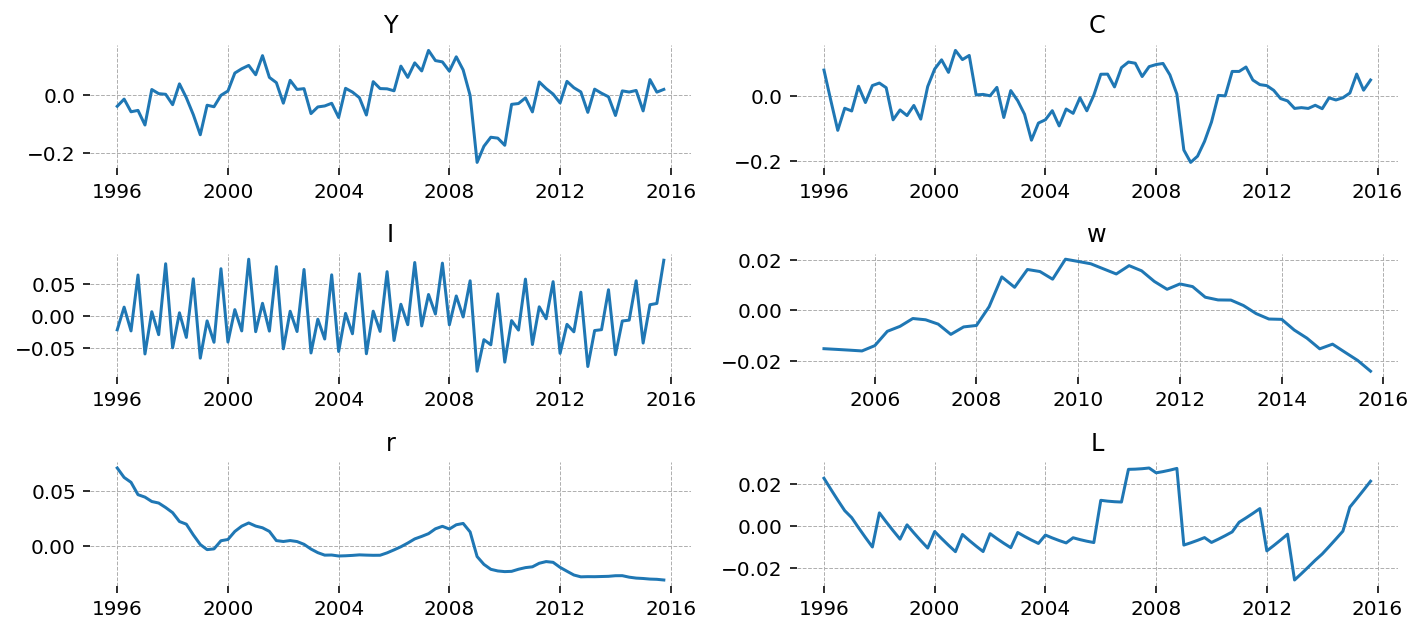

In [142]:
plot_df(train)

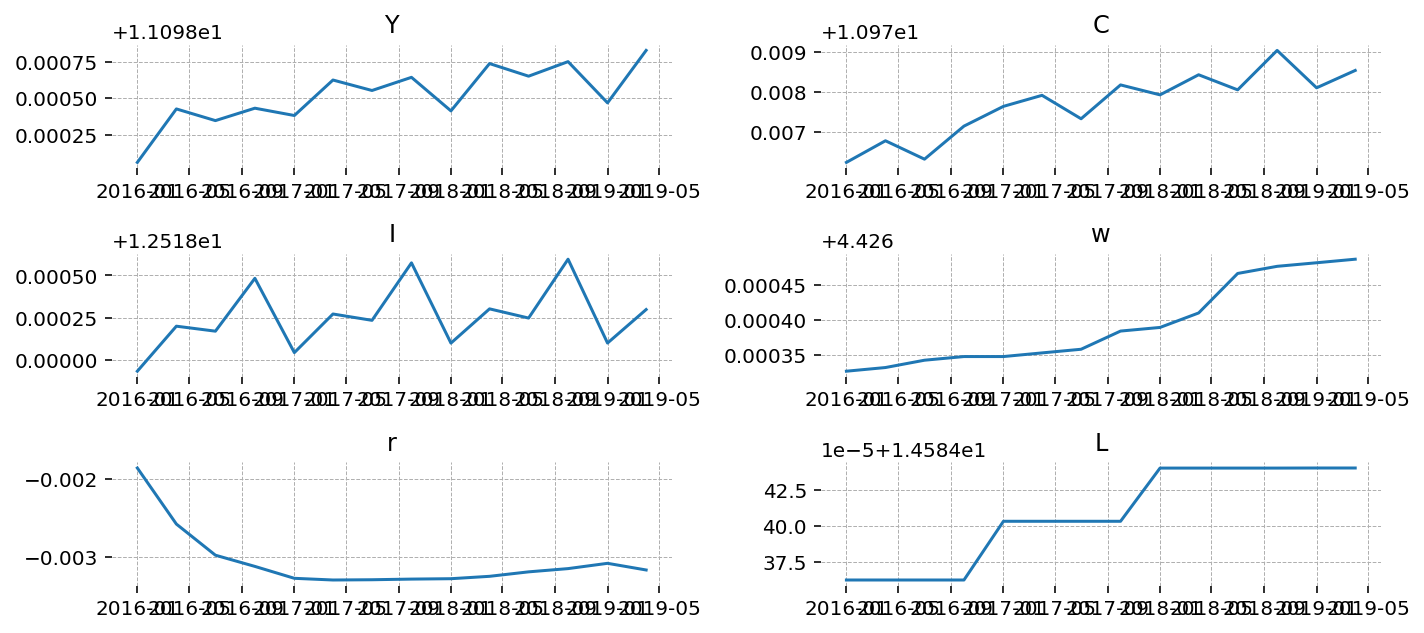

In [143]:
plot_df(test)

### Deseasonalise the Data <a class="anchor" id="section_3_2"></a>

In [144]:
desea_cols = ['Y', 'I', 'C', 'w', 'L'] # r not seasonal
for col in desea_cols:
    train[col] = get_seasonal_hp(train[col], lamb=6.25, skipna=True)
    test[col] = get_seasonal_hp(test[col], lamb=6.25, skipna=True)

For deseasonalisation we chose the Hodrick-Prescott filter, which identifies the underlying trend

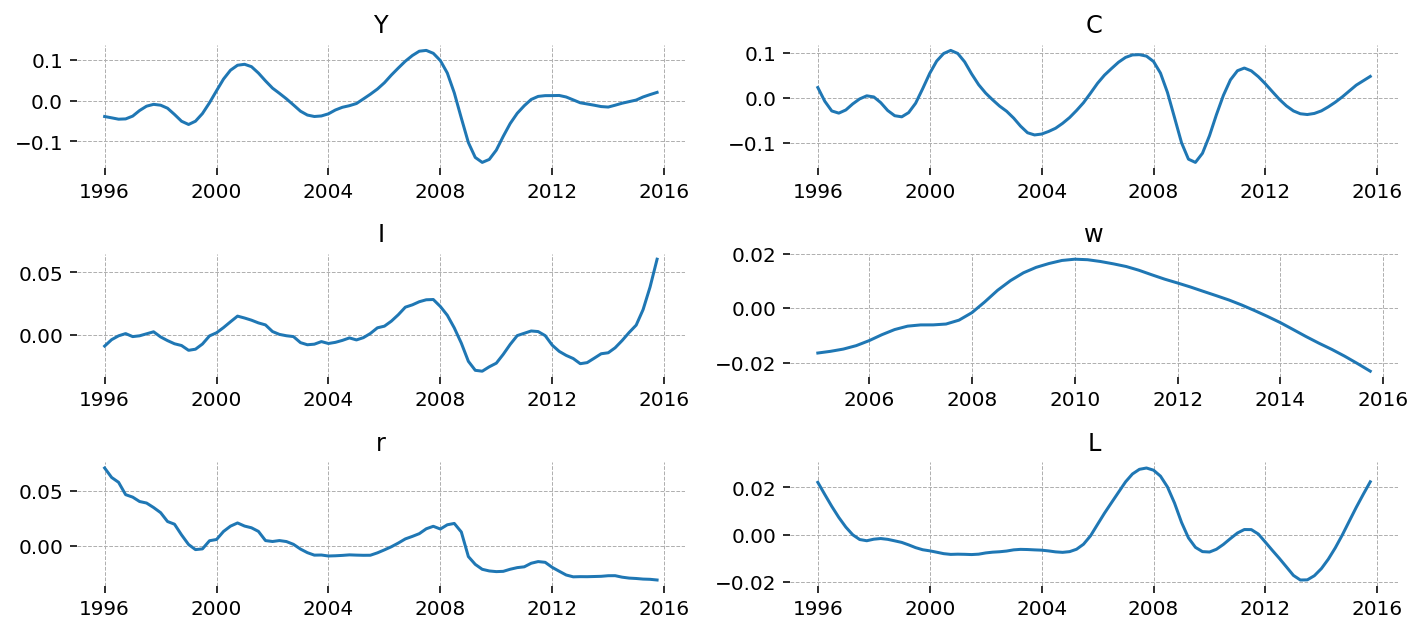

In [145]:
plot_df(train)

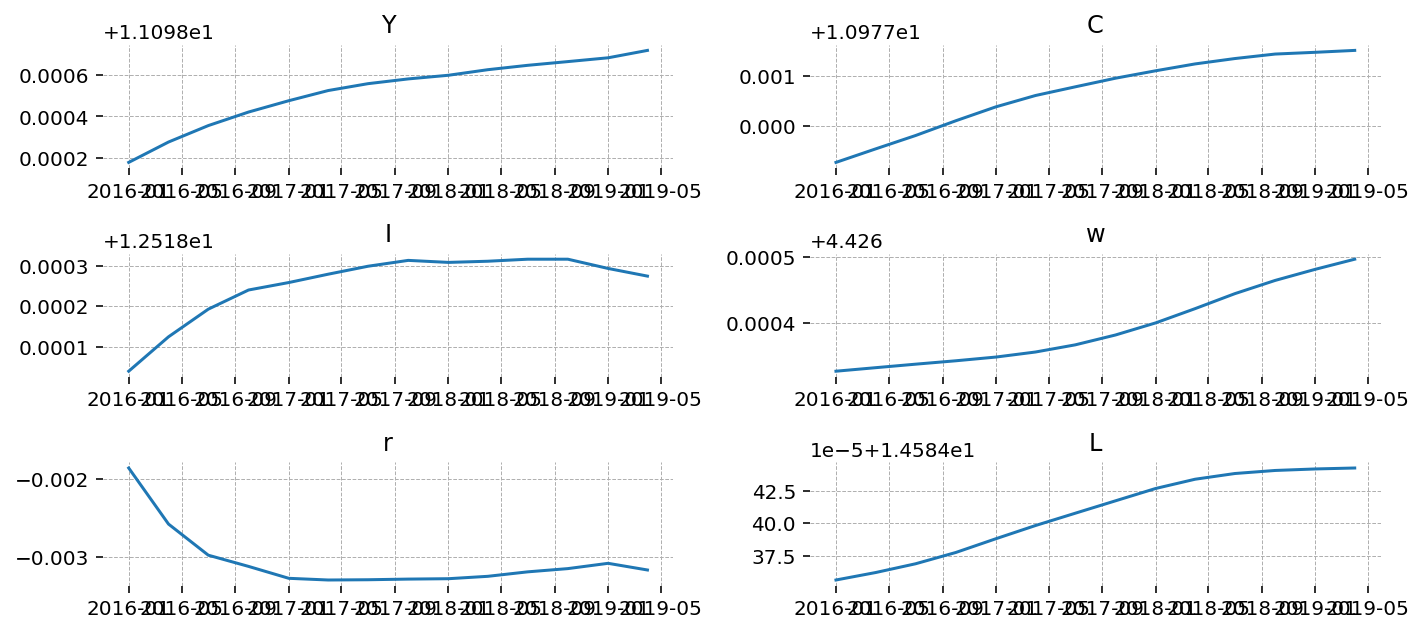

In [146]:
plot_df(test)

### Check stationarity after tranformation <a class="anchor" id="section_3_3"></a>

In [147]:
ADF_test_summary(train, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.034         -3.029        0.124          8    -4.092      -3.474     -3.164
	Constant             0.001          0.818        0.416
	Trend               -0.000         -0.605        0.548
Constant Only               -0.033         -2.989        0.036          8    -3.526      -2.903     -2.589
	Constant             0.000          0.598        0.552
No Constant                 -0.032         -2.971        0.003          8    -2.598      -1.945     -1.614
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

In [148]:
for col in train.columns:
    arr_adf(train[col], skipna=True, p_level=.1)

Y  p-val: 0.03592287849841063,  reject: True
I  p-val: 0.3773284735056144,  reject: False
r  p-val: 0.1510093430743939,  reject: False
C  p-val: 0.0034255649752212977,  reject: True
w  p-val: 0.5070976795468213,  reject: False
L  p-val: 0.07386446228221183,  reject: True


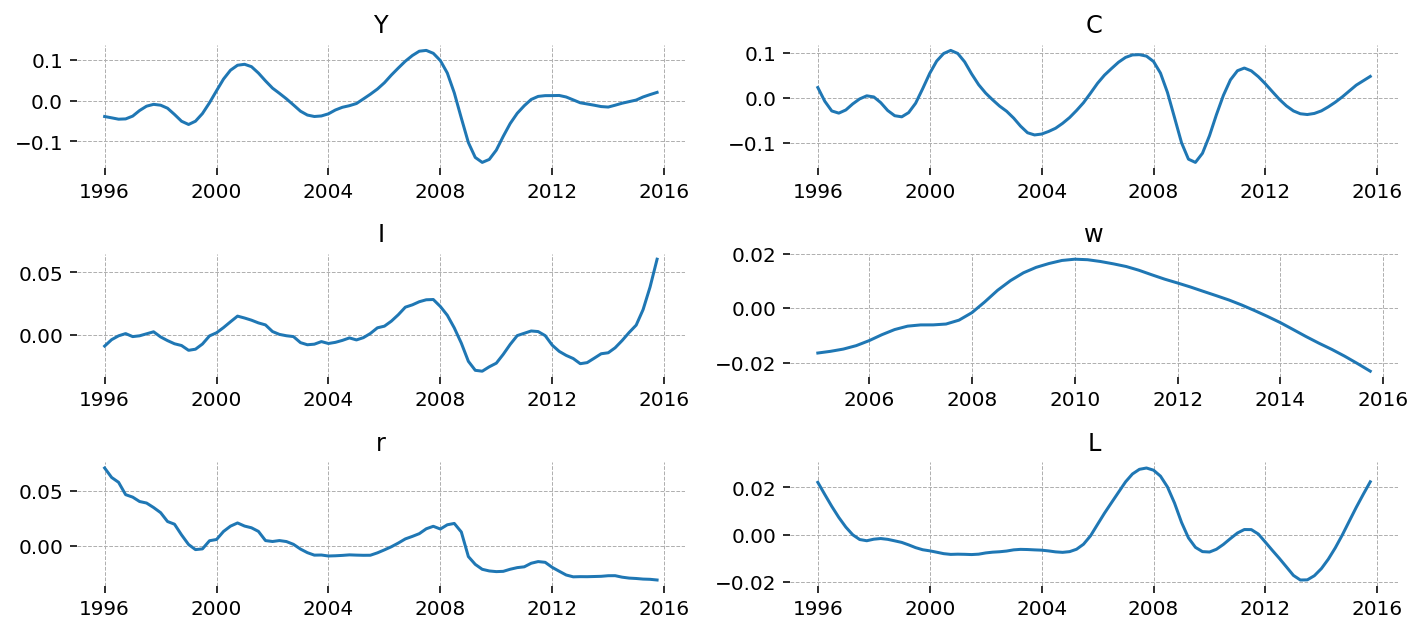

In [149]:
plot_df(train)

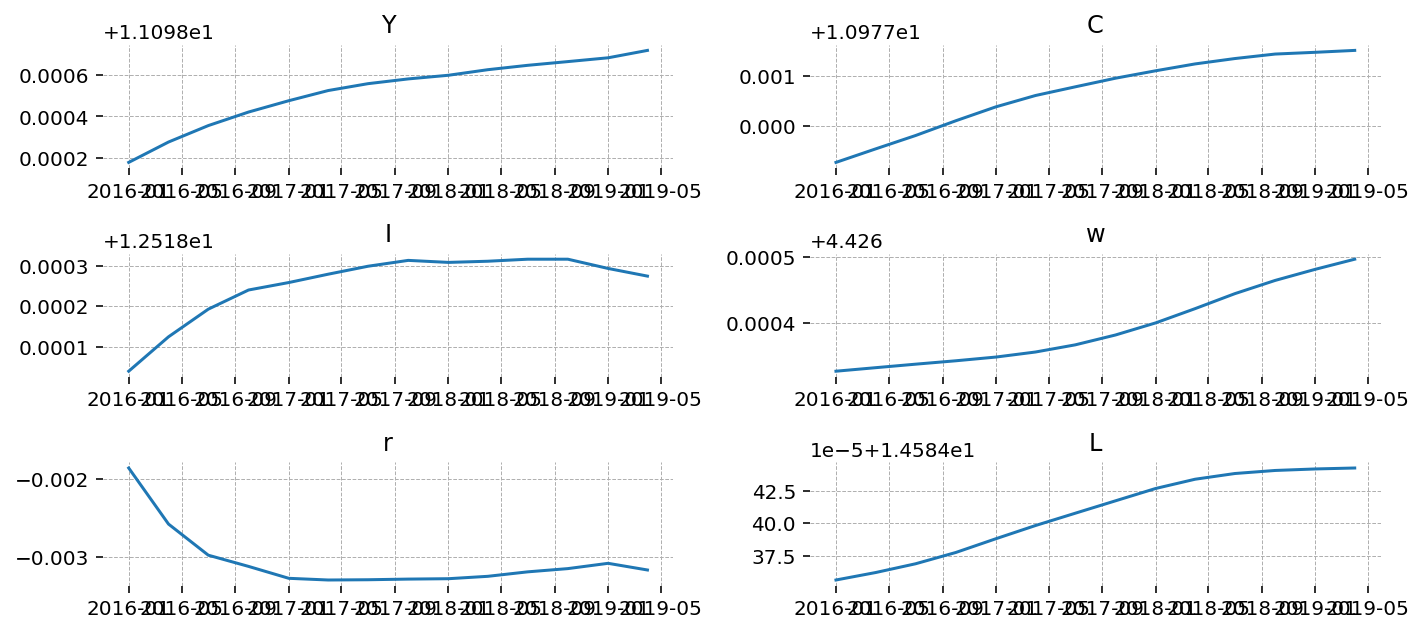

In [150]:
plot_df(test)

# Make RBC Model <a class="anchor" id="chapter1"></a>

In [151]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc.gnc'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 3 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations  c

In [152]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_1_2"></a>

In [153]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 5.05225966748797e-27
Solution found, sum of squared residuals:  1.5983560431973124e-28
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [154]:
rbc.print_steady_state()

A_ss               1.000
C_ss              11.649
I_ss               4.026
K_ss             402.632
L_ss               4.952
Y_ss              15.675
lambda_ss          0.983
r_ss               0.010
w_ss               2.336


## Check Blanchard Kahn Conditions

In [155]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,6.736812e-31,-6.736812e-31,-0.0
1,2.239773e-19,2.239773e-19,0.0
2,1.319356e-17,1.319356e-17,0.0
3,2.817686e-17,2.817686e-17,0.0
4,3.407138e-17,3.407138e-17,0.0
5,8.642163e-01,8.642163e-01,0.0
6,9.405000e-01,9.405000e-01,0.0
7,1.157349e+00,1.157349e+00,0.0
8,2.385573e+06,2.385573e+06,0.0


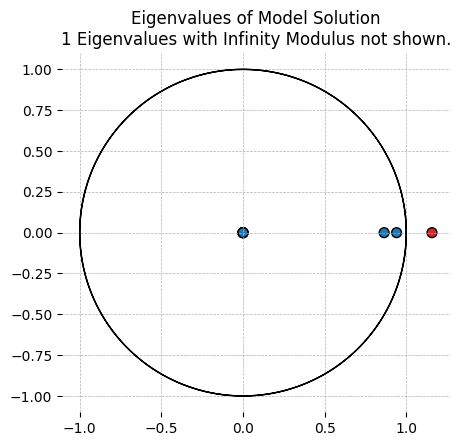

In [156]:
gp.plot_eigenvalues(rbc);

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [157]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,-0.038572,-0.008759,0.070174,0.022497,NaN,0.022162
1996-04-01,-0.041820,-0.003640,0.061707,-0.007947,NaN,0.017030
1996-07-01,-0.045196,-0.000573,0.057340,-0.029443,NaN,0.012016
1996-10-01,-0.044496,0.001199,0.046274,-0.034302,NaN,0.007327
1997-01-01,-0.037604,-0.001199,0.044074,-0.027251,NaN,0.003230


In [158]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [159]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [160]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# NOTE: We have to change this parameters probably

param_start_dict = {
#     'sigma_C':1.5, 
#     'sigma_L':2.0,
#     'alpha':0.5,
    'rho_A':0.85
                   }

shock_start_dict = {
    'epsilon_A':0.5
                    }

noise_start_dict = {
#     'Y':0.01,
#     'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
#     'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
#     'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
    'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, # If None, will automatically transform to positive values only
                   noise_transforms=None, # If None, will automatically transform to positive values only
                   initialization='stationary')

In [161]:
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

# mle_res = mle_mod.fit(method='nm', maxiter=10_00)
# mle_res = mle_mod.fit(method='lbfgs', maxiter=1_000, start_params=mle_res.params)

basinhopping step 0: f -2.35714
basinhopping step 1: f -2.38685 trial_f -2.38685 accepted 1  lowest_f -2.38685
found new global minimum on step 1 with function value -2.38685
basinhopping step 2: f -2.39521 trial_f -2.39521 accepted 1  lowest_f -2.39521
found new global minimum on step 2 with function value -2.39521
basinhopping step 3: f -2.39415 trial_f -2.39415 accepted 1  lowest_f -2.39521
basinhopping step 4: f -2.41338 trial_f -2.41338 accepted 1  lowest_f -2.41338
found new global minimum on step 4 with function value -2.41338
basinhopping step 5: f -2.38872 trial_f -2.38872 accepted 1  lowest_f -2.41338
basinhopping step 6: f -2.41536 trial_f -2.41536 accepted 1  lowest_f -2.41536
found new global minimum on step 6 with function value -2.41536
basinhopping step 7: f -2.41441 trial_f -2.41441 accepted 1  lowest_f -2.41536
basinhopping step 8: f -2.41985 trial_f -2.41985 accepted 1  lowest_f -2.41985
found new global minimum on step 8 with function value -2.41985
basinhopping ste

basinhopping step 61: f -2.39025 trial_f -2.39025 accepted 1  lowest_f -2.44737
basinhopping step 62: f -2.41763 trial_f -2.41763 accepted 1  lowest_f -2.44737
basinhopping step 63: f -2.44998 trial_f -2.44998 accepted 1  lowest_f -2.44998
found new global minimum on step 63 with function value -2.44998
basinhopping step 64: f -2.43087 trial_f -2.43087 accepted 1  lowest_f -2.44998
basinhopping step 65: f -2.45072 trial_f -2.45072 accepted 1  lowest_f -2.45072
found new global minimum on step 65 with function value -2.45072
basinhopping step 66: f -2.43721 trial_f -2.43721 accepted 1  lowest_f -2.45072
basinhopping step 67: f -2.44283 trial_f -2.44283 accepted 1  lowest_f -2.45072
basinhopping step 68: f -2.42788 trial_f -2.42788 accepted 1  lowest_f -2.45072
basinhopping step 69: f -2.42709 trial_f -2.42709 accepted 1  lowest_f -2.45072
basinhopping step 70: f -2.39721 trial_f -2.39721 accepted 1  lowest_f -2.45072
basinhopping step 71: f -2.39912 trial_f -2.39912 accepted 1  lowest_f

In [170]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                   80
Model:                      DSGEModel   Log Likelihood                  49.382
Date:                Wed, 07 Dec 2022   AIC                            -94.764
Time:                        15:53:41   BIC                            -90.000
Sample:                    01-01-1996   HQIC                           -92.854
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9849      0.027     36.812      0.000       0.932       1.037
sigma2.epsilon_A     0.0105      0.002      4.368      0.000       0.006       0.015
===================================================================================
Ljung-Box (L1) (Q):                  66.80   Jarque-Bera (JB):                22.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.83
Prob(H) (two-sided):                  0.88   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

## MLE Kalman Filter Prediction <a class="anchor" id="section_4_1"></a>

In [171]:
from src.utils import plot_sm_results

In [180]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

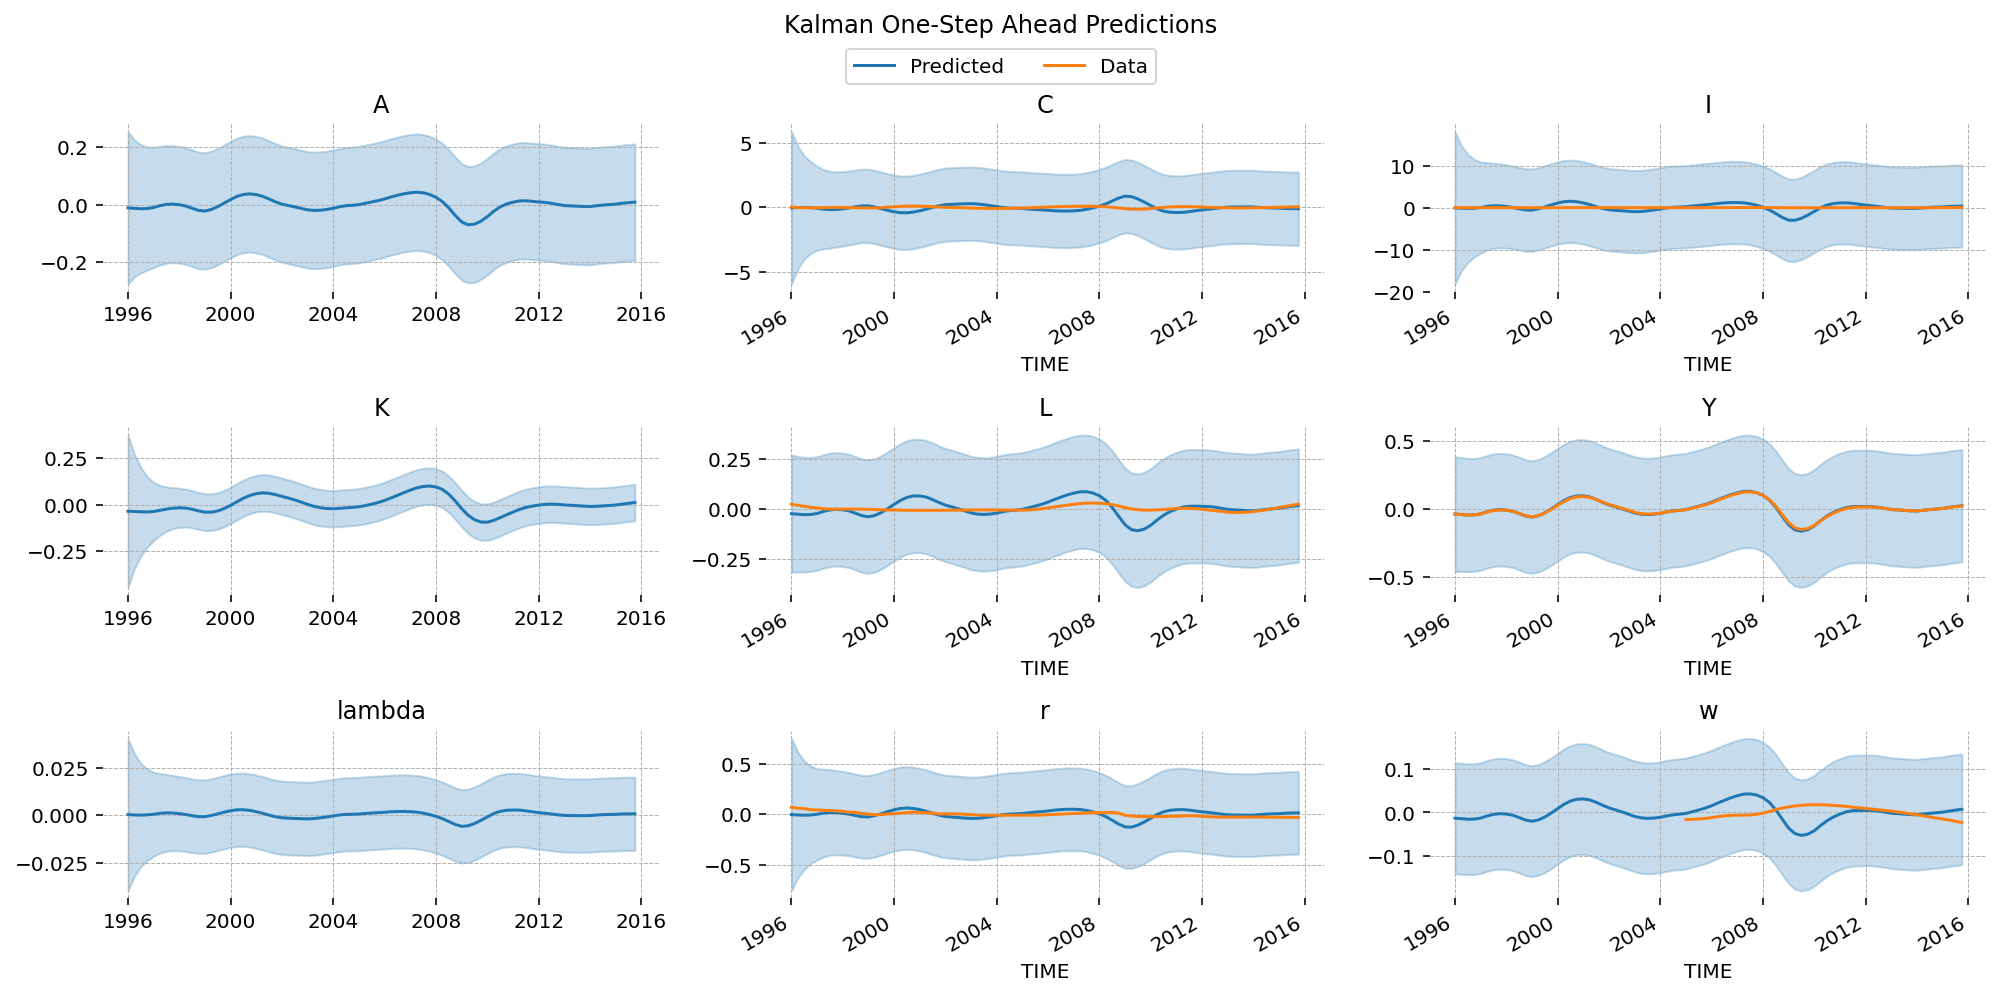

In [181]:
plot_sm_results(mle_res, train, var_names=vars_to_plot)

## Kalman Smoother output <a class="anchor" id="section_4_2"></a>

In [ ]:
plot_sm_results(mle_res, train, 'smoothed', var_names=vars_to_plot)

In [167]:
test

,Y,I,r,C,w,L
TIME,,,,,,
2016-01-01,11.098179,12.518039,-0.001861,10.976275,4.426328,14.584356
2016-04-01,11.098277,12.518124,-0.002581,10.976546,4.426333,14.584362
2016-07-01,11.098356,12.518193,-0.002981,10.976813,4.426338,14.584369
2016-10-01,11.098421,12.518240,-0.003125,10.977109,4.426343,14.584377
2017-01-01,11.098476,12.518259,-0.003278,10.977388,4.426349,14.584388
2017-04-01,11.098525,12.518279,-0.003300,10.977614,4.426357,14.584398
2017-07-01,11.098558,12.518299,-0.003296,10.977788,4.426368,14.584408
2017-10-01,11.098581,12.518313,-0.003288,10.977960,4.426382,14.584417
2018-01-01,11.098598,12.518308,-0.003283,10.978109,4.426401,14.584427


## Forecasting

In [127]:
mle_forecast = mle_res.get_forecast(steps=test_size)

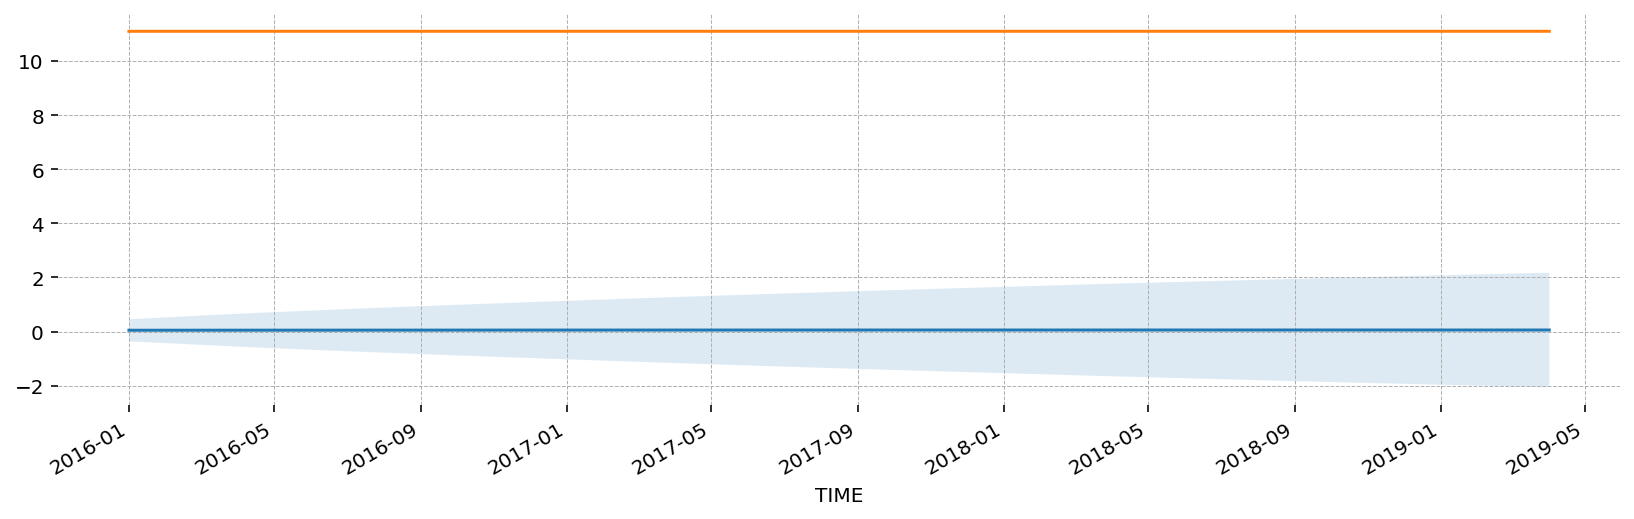

In [129]:
mu = mle_forecast.predicted_mean

# var_pred_mean is the variance, but the 95% CI will be +/- 1.96 * std, so we have to take square root.
sigma = 1.96 * np.sqrt(mle_forecast.var_pred_mean)

fig, ax = plt.subplots()
ax.plot(mu)
ax.fill_between(mu.index, mu - sigma, mu + sigma, alpha=0.15)
test.Y.plot(ax=ax)
plt.show()

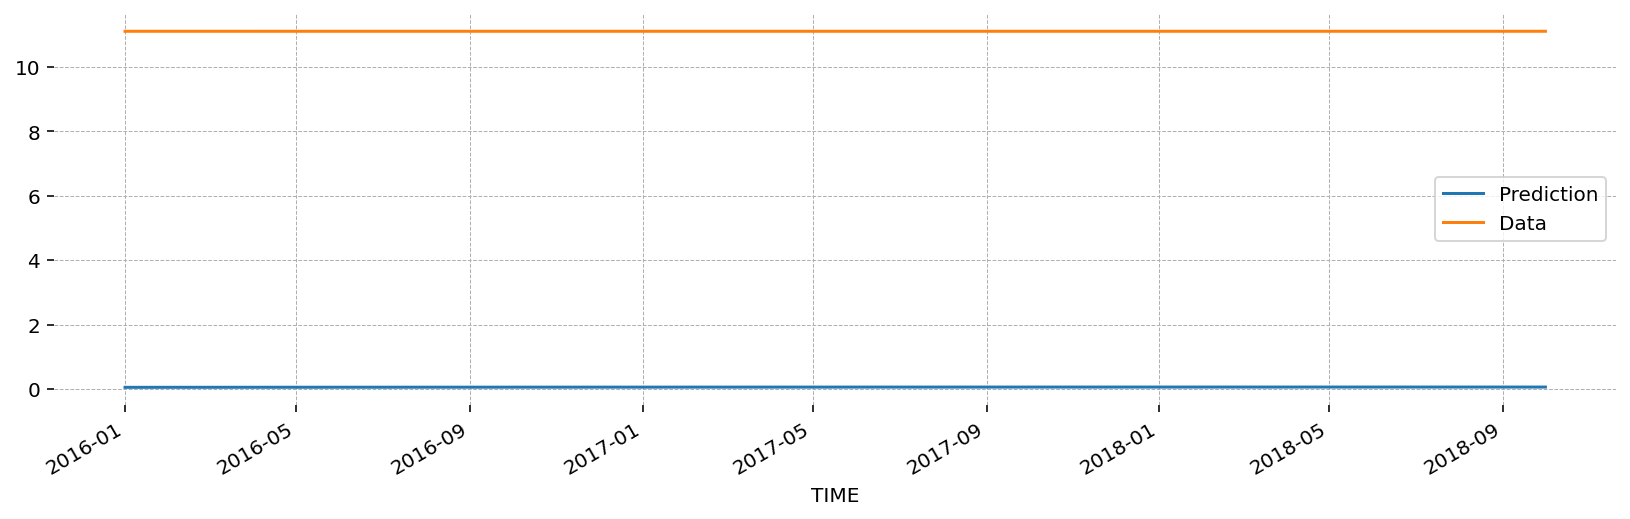

In [130]:
fig, ax = plt.subplots()
n_quarters = 12

ax.plot(mu.iloc[:n_quarters], label='Prediction')
test.Y.iloc[:n_quarters].plot(ax=ax, label='Data')
ax.legend()
plt.show()

### Kalman filter + observation nouse

In [169]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# NOTE: We have to change this parameters probably

param_start_dict = {
#     'sigma_C':1.5, 
#     'sigma_L':2.0,
#     'alpha':0.5,
    'rho_A':0.85
                   }

shock_start_dict = {
    'epsilon_A':0.5
                    }

noise_start_dict = {
    'Y':0.01,
#     'C':0.02,
#     'L':0.05,
#     'I':0.02,
#     'r':0.03,
#     'w':0.1
                    }

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
#     'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
#     'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
#     'alpha':IntervalTransformer(low=0.0001, high=0.99, slope=1)
}

mle_mod = MLEModel(train[["Y"]],
                   param_start_dict = param_start_dict,
                   shock_start_dict = shock_start_dict,
                   noise_start_dict = noise_start_dict,
                   param_transforms = param_transforms,
                   shock_transforms=None, # If None, will automatically transform to positive values only
                   noise_transforms=None, # If None, will automatically transform to positive values only
                   initialization='stationary')

In [ ]:
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'})

# mle_res = mle_mod.fit(method='nm', maxiter=10_00)
# mle_res = mle_mod.fit(method='lbfgs', maxiter=1_000, start_params=mle_res.params)

## Impulse response <a class="anchor" id="section_4_3"></a>

In [57]:
irf_df = mle_res.impulse_responses(impulse=0, steps=1_000, orthogonalized=False)
irf_df.index = pd.MultiIndex.from_product([irf_df.index, ['epsilon_A']], names=['Time', 'Shocks'])
irf_df.columns.name = 'Variables'

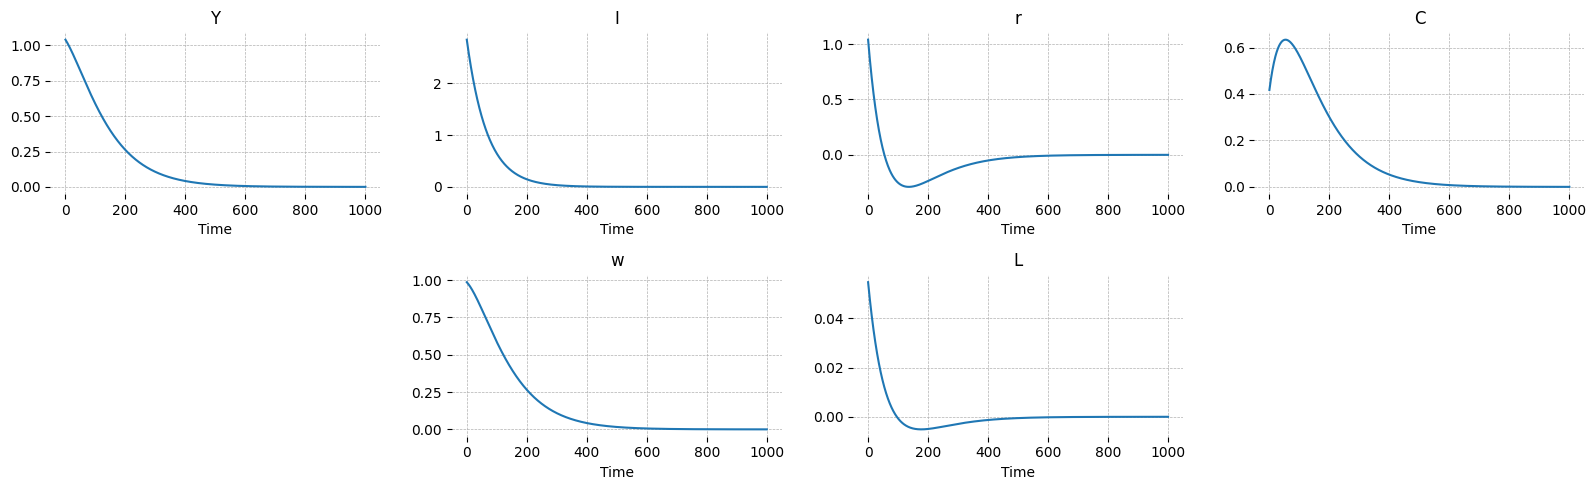

In [58]:
fig = gp.plot_irf(irf_df.T, shocks_to_plot='epsilon_A', figsize=(16,5))
plt.show()

### New Steady State

In [59]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.342
I_ss               0.809
K_ss              80.948
L_ss               0.996
Y_ss               3.151
lambda_ss          0.409
r_ss               0.010
w_ss               2.336


In [61]:
rbc.param_priors

{'sigma_C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x208e1f92850>,
 'sigma_L': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x208ddc3cd30>,
 'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x208e1f92c40>}

In [62]:
mle_mod.param_names

['sigma_C',
 'sigma_L',
 'rho_A',
 'sigma2.epsilon_A',
 'sigma2.C',
 'sigma2.L',
 'sigma2.I',
 'sigma2.r',
 'sigma2.w']

### Forecasting